Name: Syed Mohamad Tawseeq          
ROll: 22CH10090

In [ ]:
import os #here we import necessary libs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz #download the raw dataset zips
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

In [ ]:
!tar -xvzf images.tar.gz #unzip those raw zips
!tar -xvzf annotations.tar.gz

In [ ]:
!ls #check the current dir

annotations  annotations.tar.gz  images  images.tar.gz


In [ ]:
!mkdir oxford_pets #make a new clean dir and move
!mv images annotations oxford_pets/

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #check cuda


cuda


In [ ]:
class OxfordPetsDataset(Dataset):
    def __init__(self, root, split="train", img_size=128):
        self.root = root # root is dataset folder path
        self.img_size = img_size
        images_dir = os.path.join(root, "images") # path where the jpg images are stored
        masks_dir = os.path.join(root, "annotations", "trimaps") #.png files , eahc pizel has class label
        split_file = "trainval.txt" if split != "test" else "test.txt" #file naming and split
        split_path = os.path.join(root, "annotations", split_file) 
        with open(split_path, "r") as f: #we need the filename only so line.split()[0]
            files = [line.split()[0] for line in f.readlines()]
        #  train val split
        if split == "train":
            files = files[:int(0.9 * len(files))]
        elif split == "val":
            files = files[int(0.9 * len(files)):]

        self.image_paths = [os.path.join(images_dir, f + ".jpg") for f in files]
        self.mask_paths = [os.path.join(masks_dir, f + ".png") for f in files]
        self.img_transform = transforms.Compose([  # image transforms
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        self.mask_resize = transforms.Resize( # mask resize nearest
            (img_size, img_size),
            interpolation=Image.NEAREST
        )
    def __len__(self):
        return len(self.image_paths) # no of samples in dataset =no.of image paths
    def __getitem__(self, idx): #loads image and mask for the given index
        img = Image.open(self.image_paths[idx]).convert("RGB") #3 channed input
        mask = Image.open(self.mask_paths[idx]) #single chanel

        img = self.img_transform(img) #normalization

        mask = self.mask_resize(mask)
        mask = torch.from_numpy(np.array(mask)).long() #mask need to be integer class IDs

        # original labels= 1 2 3 , shift to 0, 1,2
        mask = mask - 1

        return img, mask


In [ ]:
def show_samples(dataset, n=5):
    plt.figure(figsize=(10, 2*n)) #fig where each sample will take 2 rows:
    for i in range(n):
        img, mask = dataset[i] #get
        img = img.permute(1, 2, 0).numpy() #convert for numpy
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) #img = img * std + mean
        img = np.clip(img, 0, 1) #some can go beyond this

        plt.subplot(n, 2, 2*i+1) #left column
        plt.imshow(img)
        plt.title("image")
        plt.axis("off")

        plt.subplot(n, 2, 2*i+2) #right column
        plt.imshow(mask, cmap="gray")
        plt.title("mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
class DoubleConv(nn.Module):
    # A basic U-Net block:
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes=3, use_skip=True):
        super().__init__()
        self.use_skip = use_skip
        #Encoder block here - downsampling path
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2) #MaxPool

        self.middle = DoubleConv(512, 1024) #Bottleneck
        # Decoder - upsampling path
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024 if use_skip else 512, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512 if use_skip else 256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256 if use_skip else 128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128 if use_skip else 64, 64)
        # Output shape: (B, num of classes, H, W)
        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        #Encoder forward
        e1 = self.enc1(x) # (B, 64, H, W)
        e2 = self.enc2(self.pool(e1)) # (B, 128, H/2, W/2)
        e3 = self.enc3(self.pool(e2)) # (B, 256, H/4, W/4)
        e4 = self.enc4(self.pool(e3)) # (B, 512, H/8, W/8)

        # Bottleneck
        m = self.middle(self.pool(e4))      #(B, 1024, H/16, W/16)
        # Decoder forward
        d4 = self.up4(m)    # (B, 512, H/8, W/8)
        if self.use_skip:
            d4 = torch.cat([d4, e4], dim=1) #B, 1024, H/8, W/8 , simple concat if skip is true
        d4 = self.dec4(d4)

        d3 = self.up3(d4) #B, 256, H/4, W/4
        if self.use_skip:
            d3 = torch.cat([d3, e3], dim=1)     #B, 512, H/4, W/4
        d3 = self.dec3(d3)

        d2 = self.up2(d3) #B, 128, H/2, W/2
        if self.use_skip:
            d2 = torch.cat([d2, e2], dim=1)     #B, 256, H/2, W/2
        d2 = self.dec2(d2)

        d1 = self.up1(d2)       #B, 64, H, W
        if self.use_skip:
            d1 = torch.cat([d1, e1], dim=1)     #B, 128, H, W
        d1 = self.dec1(d1)
        return self.final(d1)


In [ ]:
def pixel_accuracy(pred, mask):
    correct = (pred == mask).sum().item() #simple comparision
    total = mask.numel()
    return correct / total


In [ ]:
def mean_iou(pred, mask, num_classes=3):
    ious = [] #store ious
    for cls in range(num_classes):
        pred_c = pred == cls #True where prediction == cls
        mask_c = mask == cls    #True where ground truth == cls

        intersection = (pred_c & mask_c).sum().item() # when both are cls
        union = (pred_c | mask_c).sum().item() #when either is cls

        if union > 0: #skip to avoid div by zero
            ious.append(intersection / union)

    return sum(ious) / len(ious)


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
#a simple training loop from test loader
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_iou = 0
    with torch.no_grad():
        # a simple testing loop just like traininbg but grads are frozen here 
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            loss = criterion(preds, masks)

            labels = torch.argmax(preds, dim=1)

            total_loss += loss.item()
            total_acc += pixel_accuracy(labels, masks)
            total_iou += mean_iou(labels, masks)

    n = len(loader)
    return total_loss/n, total_acc/n, total_iou/n


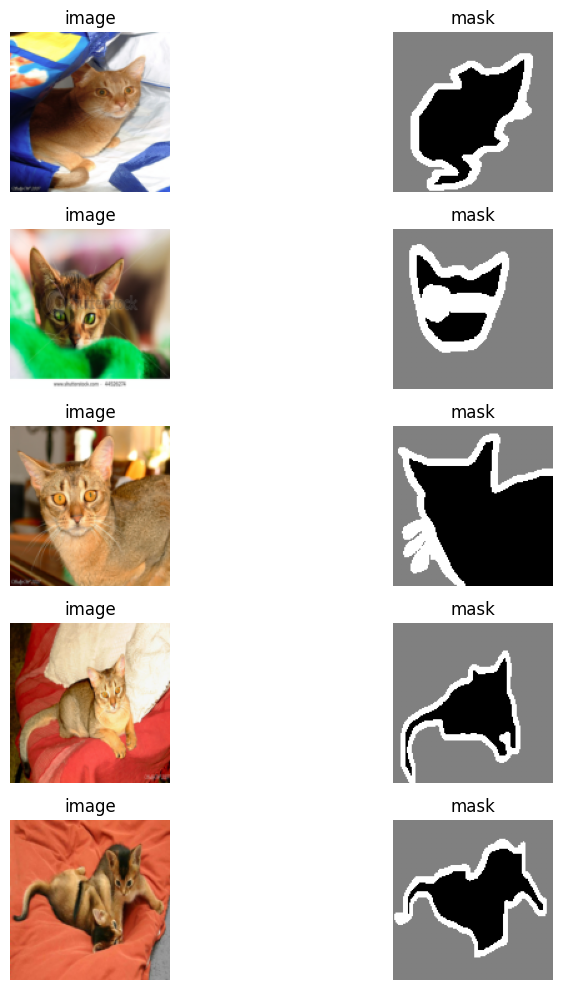

In [ ]:
train_ds = OxfordPetsDataset("oxford_pets", "train") #load the actual dataset
val_ds = OxfordPetsDataset("oxford_pets", "val")
test_ds = OxfordPetsDataset("oxford_pets", "test")

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True) #use dataloader to form tensors
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

show_samples(train_ds) #see samples

In [ ]:
model = UNet(num_classes=3, use_skip=True).to(device) #move the model to device after initializing it
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) #optim

epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs): #training loop
    tr_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_iou = eval_epoch(model, val_loader, criterion)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)

    print(f"epoch {epoch+1}: train loss {tr_loss:.4f}, val loss {val_loss:.4f}, acc {val_acc:.4f}, miou {val_iou:.4f}")


epoch 1: train loss 0.7642, val loss 0.6466, acc 0.7282, miou 0.4283
epoch 2: train loss 0.6517, val loss 0.6367, acc 0.7359, miou 0.4482
epoch 3: train loss 0.5893, val loss 0.5045, acc 0.7993, miou 0.5379
epoch 4: train loss 0.5022, val loss 0.5280, acc 0.7978, miou 0.5492
epoch 5: train loss 0.4505, val loss 0.5218, acc 0.7817, miou 0.5460
epoch 6: train loss 0.4189, val loss 0.4057, acc 0.8446, miou 0.6233
epoch 7: train loss 0.3835, val loss 0.3940, acc 0.8484, miou 0.6305
epoch 8: train loss 0.3644, val loss 0.3744, acc 0.8547, miou 0.6339
epoch 9: train loss 0.3518, val loss 0.4449, acc 0.8253, miou 0.6106
epoch 10: train loss 0.3426, val loss 0.3351, acc 0.8709, miou 0.6568
epoch 11: train loss 0.3111, val loss 0.3374, acc 0.8726, miou 0.6623
epoch 12: train loss 0.3061, val loss 0.3558, acc 0.8661, miou 0.6611
epoch 13: train loss 0.2966, val loss 0.3253, acc 0.8753, miou 0.6677
epoch 14: train loss 0.2758, val loss 0.3178, acc 0.8783, miou 0.6788
epoch 15: train loss 0.2656, 

In [ ]:
test_loss, test_acc, test_iou = eval_epoch(model, test_loader, criterion) #test/ evaluation of the model
print("test pixel accuracy:", test_acc)
print("test miou:", test_iou)

test pixel accuracy: 0.8713549638831097
test miou: 0.6840293179778991


In [ ]:
def show_predictions(model, dataset, n=5): #visualize predictions
    model.eval() #set eval mode
    plt.figure(figsize=(12, 3*n)) #height is dep on n

    with torch.no_grad(): #no grad for memory efficiency
        for i in range(n):
            img, mask = dataset[i] 
            pred = model(img.unsqueeze(0).to(device)) #img: C,H,W to 1,C,H,W
            pred = torch.argmax(pred, dim=1).squeeze().cpu() # -> [H, W]

            img_show = img.permute(1,2,0).numpy() # (C,H,W) -> (H,W,C)
            img_show = img_show * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]) #normalization
            img_show = np.clip(img_show,0,1)

            plt.subplot(n,3,3*i+1) #original image
            plt.imshow(img_show)
            plt.title("image")
            
            plt.subplot(n,3,3*i+2) #ground truth
            plt.imshow(mask, cmap="gray")
            plt.title("gt")
            
            plt.subplot(n,3,3*i+3) #prediction image
            plt.imshow(pred, cmap="gray")
            plt.title("prediction")

    plt.tight_layout()
    plt.show()


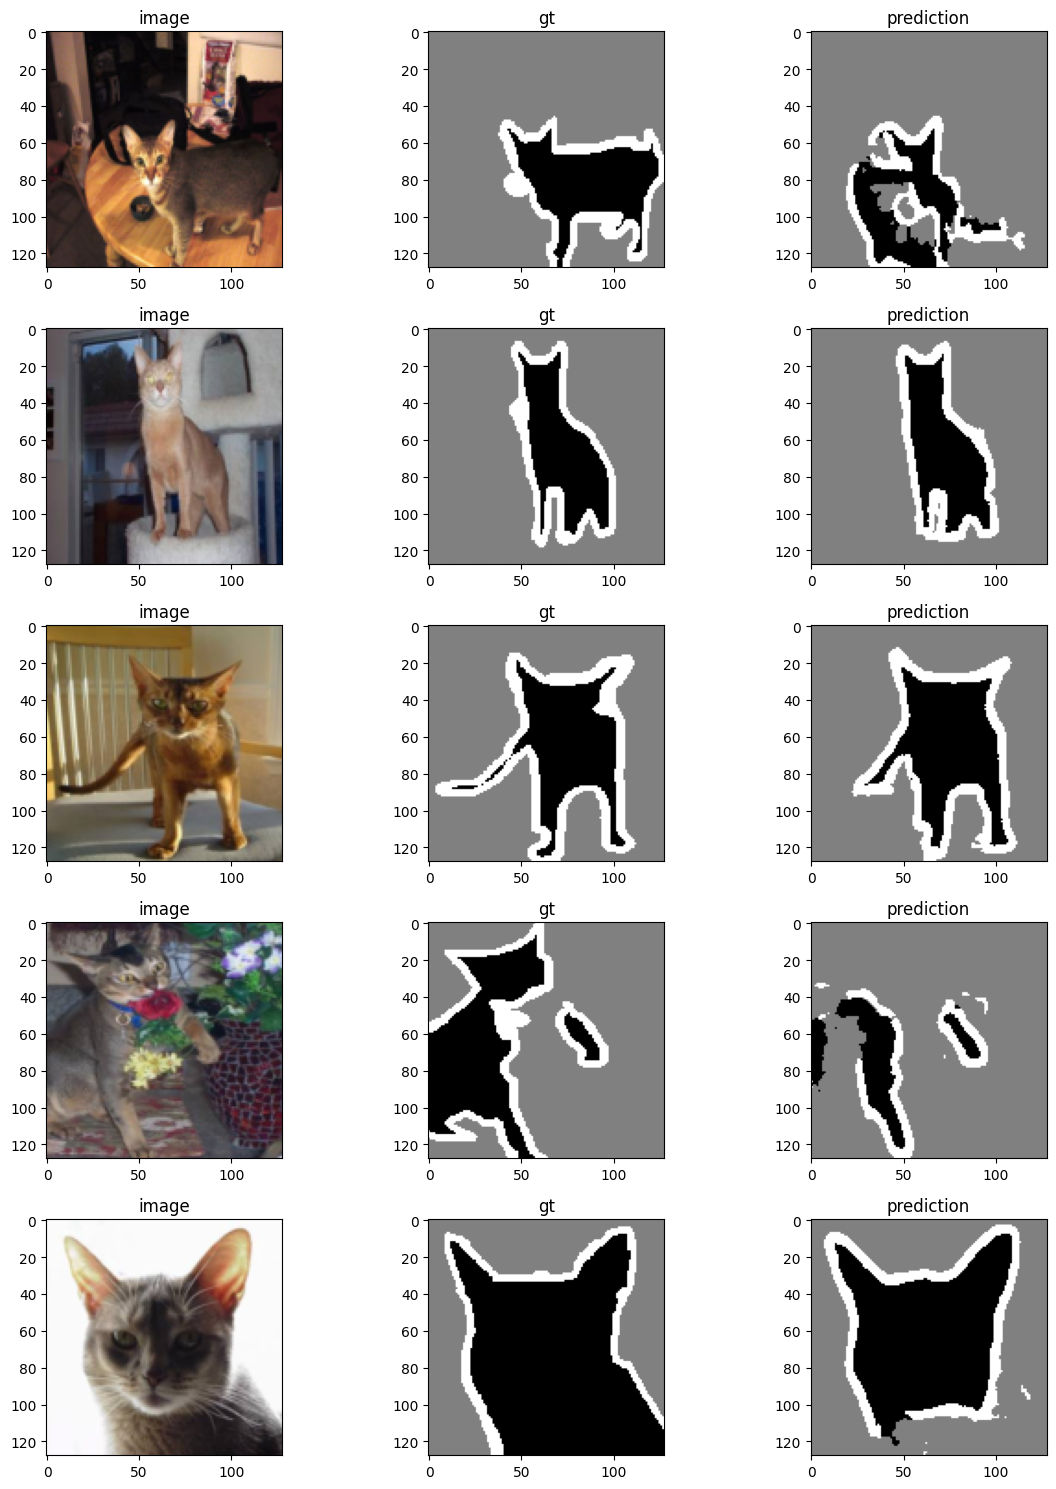

In [23]:
show_predictions(model, test_ds, n=5)

In [ ]:
model_noskip = UNet(num_classes=3, use_skip=False).to(device) #U-Net model but without skip conns
optimizer = optim.Adam(model_noskip.parameters(), lr=1e-3)

for epoch in range(epochs):#similar training loops
    train_epoch(model_noskip, train_loader, optimizer, criterion)

_, acc_ns, iou_ns = eval_epoch(model_noskip, test_loader, criterion) #eval to just get acc and intersec over union

print("no skip pixel accuracy:", acc_ns) #print results
print("no skip miou:", iou_ns)


no skip pixel accuracy: 0.6915773242452871
no skip miou: 0.36909163682273505
